Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### 

### Importing all the important libraries

In [280]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import load_img

In [159]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [160]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [161]:
# Defining the path for train and test images

data_dir_train = pathlib.Path('Data/Train')
data_dir_test = pathlib.Path('Data/Test')


In [162]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [163]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [164]:
## train dataset 
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [165]:
##  validation dataset 
## Note used seed=123 while creating  dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note,resized images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [166]:
# List out all the classes of skin cancer and store them in a list. 
# the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### code to visualize one instance of all the nine classes present in the dataset

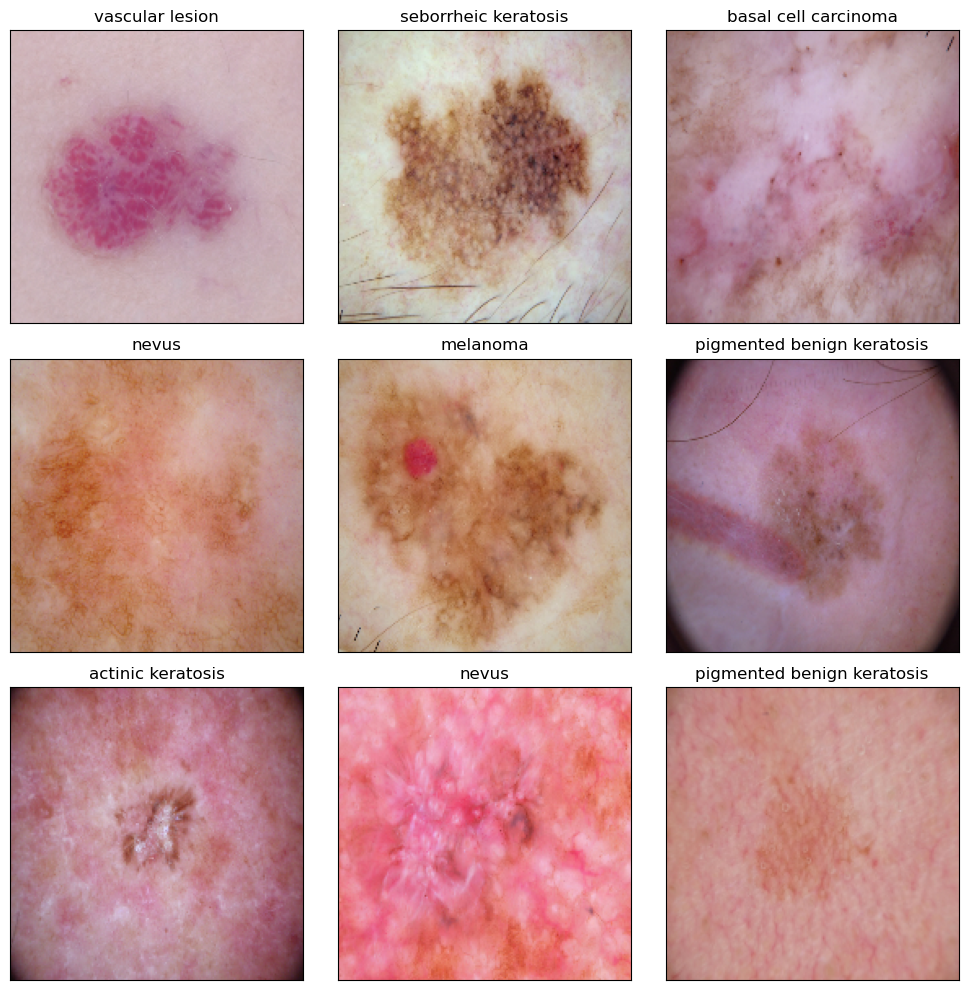

In [185]:
# Get class names from the dataset
class_names = train_ds.class_names

# Take the first batch of images and labels
images, labels = next(iter(train_ds))

# Create a figure for plotting
fig, axes = plt.subplots(3, 3, figsize=(10, 10))  # 3x3 grid for 9 classes

# Loop through each image and label, plotting them on the grid
for i, (ax, label) in enumerate(zip(axes.flat, labels)):
  # Convert the image from a tensor to a NumPy array
  image = images[i].numpy()
  # Rescale the pixel values to be between 0 and 1 
  # Assuming  images are in uint8 format (0-255),
  image = image / 255.0  # Rescale
  
  # Plot the image and label
  ax.imshow(image)
  ax.set_title(class_names[int(label)])
  ax.set_xticks([])
  ax.set_yticks([])

# Show the plot
plt.tight_layout()
plt.show()



The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [186]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### 
#### CNN model

In [187]:
### Your code goes here

#  the number of classes
num_classes = 9

# Create a Sequential model
model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])



/Users/Himanshu/anaconda3/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [188]:
### an appropirate optimiser and loss function

# Choose an optimizer
optimizer = tf.keras.optimizers.Adam()

# Choose a loss function
loss_function = tf.keras.losses.SparseCategoricalCrossentropy()

# Compile the model
model.compile(optimizer=optimizer,
              loss=loss_function,
              metrics=['accuracy'])



In [189]:
# View the summary of all layers
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_4 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,989,801 (15.22 MB)

 Trainable params: 3,989,801 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [190]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 25s 332ms/step - accuracy: 0.2719 - loss: 2.0869 - val_accuracy: 0.4318 - val_loss: 1.6794
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 17s 309ms/step - accuracy: 0.4662 - loss: 1.5479 - val_accuracy: 0.4855 - val_loss: 1.5206
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 17s 303ms/step - accuracy: 0.5185 - loss: 1.3779 - val_accuracy: 0.5391 - val_loss: 1.3535
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 17s 304ms/step - accuracy: 0.5379 - loss: 1.2926 - val_accuracy: 0.5682 - val_loss: 1.3169
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 17s 303ms/step - accuracy: 0.5817 - loss: 1.2082 - val_accuracy: 0.4966 - val_loss: 1.4174
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 17s 303ms/step - accuracy: 0.6202 - loss: 1.1122 - val_accuracy: 0.5391 - val_loss: 1.3865
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 17s 311ms/step - accuracy: 0.6007 - loss: 1.0535 - val_accuracy: 0.5459 - val_loss: 1.4031
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 17s 303ms/step - accuracy: 0.6658 - loss: 0.9410 - val_accu

### Visualizing training results

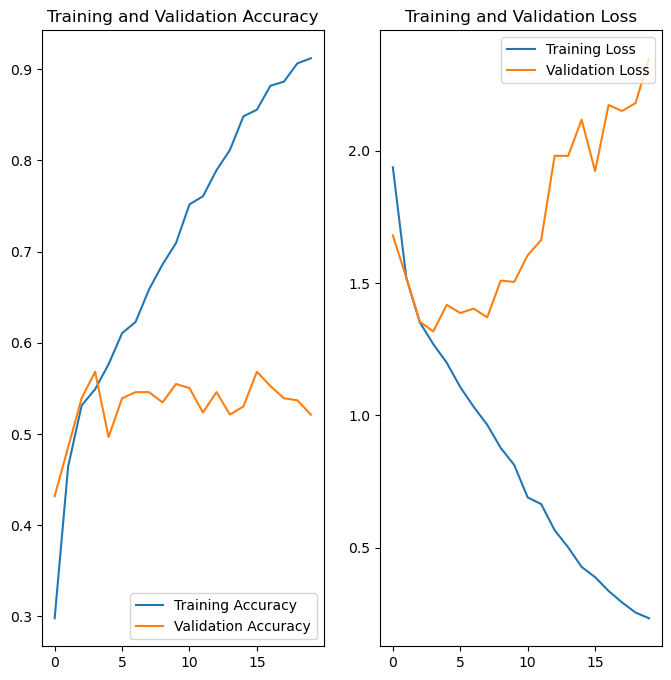

In [191]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Findings



The mode is overfillting beause 
In the graph,the training loss curve keeps decreasing throughout the epochs 
and the validation loss curve starts to increase or flattens out after a certain point, it indicates overfitting. 

This suggests the model is memorizing the training data rather than learning general patterns.

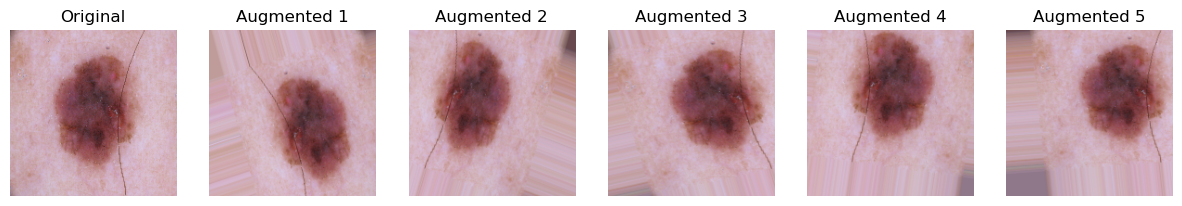

In [192]:
#  visualize how your augmentation strategy works for one instance of training image.


import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator


import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image


# Choose one image from the training dataset
img_path = 'Data/Train/melanoma/ISIC_0000139.jpg'  # Replace class_name and image_name with actual values

# Load and preprocess the original image
img = image.load_img(img_path, target_size=(img_height, img_width))

# Convert the image to a numpy array
img_array = image.img_to_array(img)
img_array = img_array.reshape((1,) + img_array.shape)  # Reshape to (1, height, width, channels)

# Create an instance of the ImageDataGenerator with the same augmentation parameters
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Generate augmented images
augmented_images = [datagen.flow(img_array).__next__() for _ in range(5)]  # Generate 5 augmented images

# Plot the original and augmented images
plt.figure(figsize=(15, 6))

# Plot the original image
plt.subplot(1, 6, 1)
plt.imshow(img)
plt.title('Original')
plt.axis('off')

# Plot the augmented images
for i, augmented_img in enumerate(augmented_images):
    plt.subplot(1, 6, i + 2)
    plt.imshow(augmented_img[0])
    plt.title(f'Augmented {i + 1}')
    plt.axis('off')

plt.show()


### 
### Model


In [193]:
## Dropout layer for overfitting 

## 
# Define the number of classes
num_classes = 9

# Create a Sequential model
model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),  # Add Dropout layer
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),  # Add Dropout layer
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),  # Add Dropout layer
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # Add Dropout layer
    layers.Dense(num_classes, activation='softmax')
])



### Compiling the model

In [194]:


# Choose an optimizer
optimizer = tf.keras.optimizers.Adam()

# Choose a loss function
loss_function = tf.keras.losses.SparseCategoricalCrossentropy()

# Compile the model
model.compile(optimizer=optimizer,
              loss=loss_function,
              metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_5 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,989,801 (15.22 MB)

 Trainable params: 3,989,801 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

### Training the model

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 337ms/step - accuracy: 0.1951 - loss: 2.6044 - val_accuracy: 0.1499 - val_loss: 2.0398
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 331ms/step - accuracy: 0.2407 - loss: 2.0168 - val_accuracy: 0.3647 - val_loss: 1.8010
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 333ms/step - accuracy: 0.2994 - loss: 1.9119 - val_accuracy: 0.3624 - val_loss: 1.7424
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 332ms/step - accuracy: 0.3658 - loss: 1.7629 - val_accuracy: 0.4004 - val_loss: 1.6645
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 333ms/step - accuracy: 0.3670 - loss: 1.7494 - val_accuracy: 0.4072 - val_loss: 1.6373
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 333ms/step - accuracy: 0.4232 - loss: 1.6118 - val_accuracy: 0.4407 - val_loss: 1.5800
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 346ms/step - accuracy: 0.4227 - loss: 1.6089 - val_accuracy: 0.4452 - val_loss: 1.5166
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 344ms/step - accuracy: 0.4358 - loss: 1.5893 - val_accu

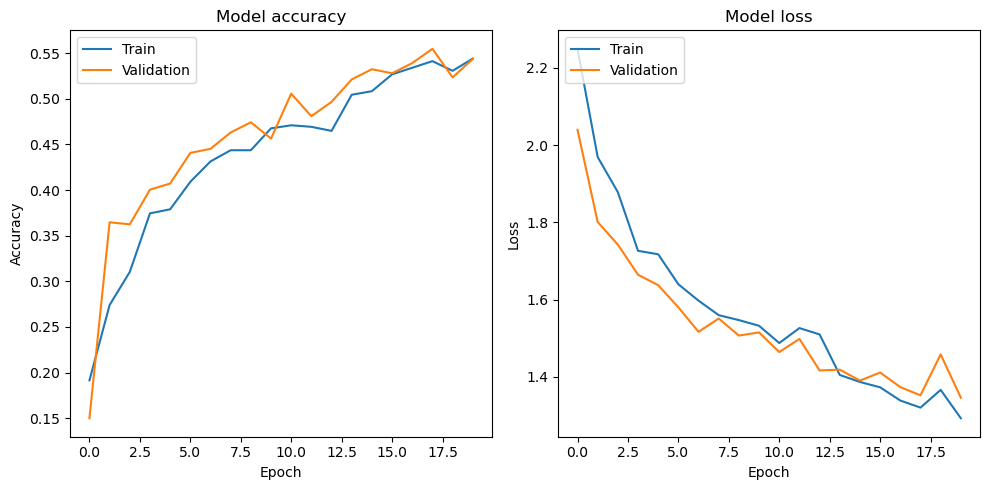

In [195]:
##  model for 20 epochs


# Train the model
epochs = 20  # Number of epochs
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

# Plot training and validation accuracy and loss
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

### Visualizing the results

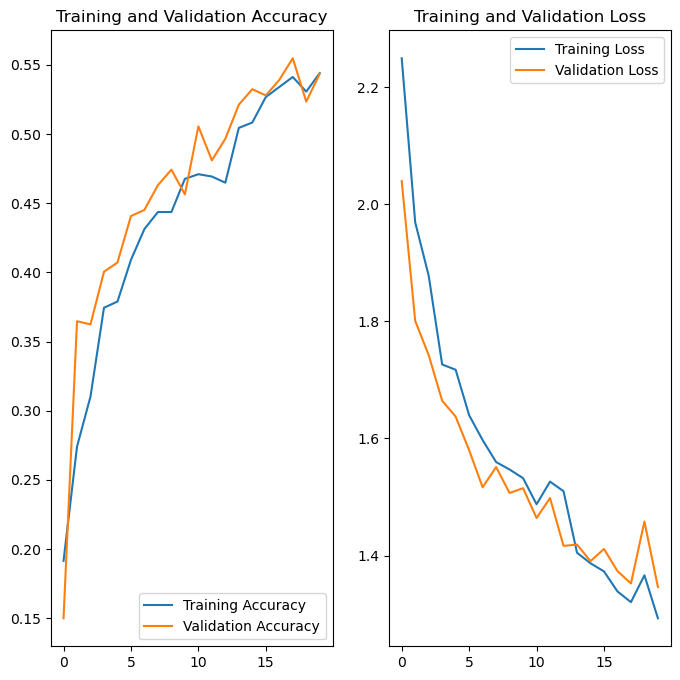

In [196]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Observation/Findings
- The model shows signs of improvement in generalizing to unseen data (higher validation accuracy),
but there's still a risk of overfitting because the training accuracy keeps increasing and the validation loss 
starts to increase later in training.
- The model shows signs of improvement in generalizing to unseen data (higher validation accuracy), 
but there's still a risk of overfitting because the training accuracy keeps increasing and the validation loss starts to increase later in training.




#### the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [239]:
# Visualize distribution of classes in the training dataset.

def class_distribution_count(directory):
    
    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))
    
    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]
    
    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', '# of Image'])

df = class_distribution_count(data_dir_train)
df

,Class,# of Image
0,melanoma,439
1,pigmented benign keratosis,462
2,nevus,357
3,basal cell carcinoma,376
4,actinic keratosis,114
5,squamous cell carcinoma,181
6,vascular lesion,139
7,seborrheic keratosis,77
8,dermatofibroma,95


<Axes: xlabel='# of Image', ylabel='Class'>

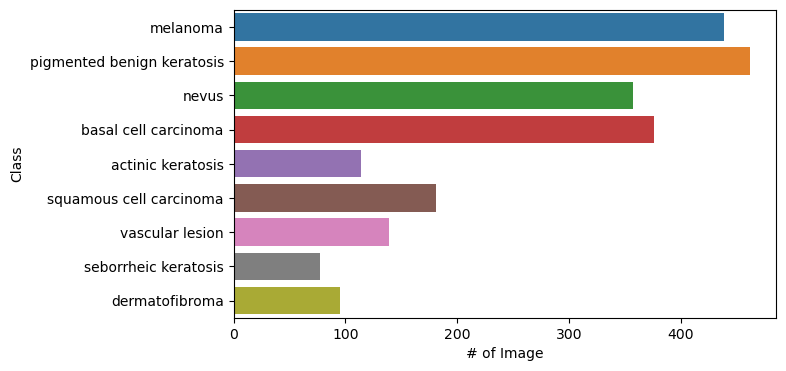

In [240]:
##
#Visualize the Number of image in each class.
import seaborn as sns
plt.figure(figsize=(7, 4))
sns.barplot(x="# of Image", y="Class", data=df,
            label="Class")

#### Findings :
There is a class imbalance to solve this using a python package Augmentor to add more samples across all classes so that none of the classes have very few samples.



#### - Which class has the least number of samples?
'seborrheic keratosis'

#### - Which classes dominate the data in terms proportionate number of samples?
 'pigmented benign keratosis' followed by 'melanoma', 'basal cell carcinoma' and 'nevus'

#### Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [199]:
# !pip install Augmentor # already installed

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [241]:
#path_to_training_dataset =  data_dir_train
from pathlib import Path

# Convert the path to a string
path_to_training_dataset = str(data_dir_train)

# Iterate through class names and apply augmentation
for i in class_names:
    p = Augmentor.Pipeline(str(path_to_training_dataset) + '/' + i)  # Convert to string before concatenating
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)

Initialised with 114 image(s) found.
Output directory set to Data/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x29F8D3D90>: 100%|█| 500/500 [00:04<00:00, 111.93 Samples


Initialised with 376 image(s) found.
Output directory set to Data/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x28DD69190>: 100%|█| 500/500 [00:04<00:00, 121.40 Samples


Initialised with 95 image(s) found.
Output directory set to Data/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x29A0578D0>: 100%|█| 500/500 [00:04<00:00, 120.72 Samples


Initialised with 438 image(s) found.
Output directory set to Data/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x29F580AD0>: 100%|█| 500/500 [00:19<00:00, 26.09 Samples


Initialised with 357 image(s) found.
Output directory set to Data/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x29A04CF50>: 100%|█| 500/500 [00:18<00:00, 26.90 Samples/


Initialised with 462 image(s) found.
Output directory set to Data/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x29F8D3890>: 100%|█| 500/500 [00:04<00:00, 110.59 Samples


Initialised with 77 image(s) found.
Output directory set to Data/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x2A00C06D0>: 100%|█| 500/500 [00:10<00:00, 48.51 Samples


Initialised with 181 image(s) found.
Output directory set to Data/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x29F3F3B50>: 100%|█| 500/500 [00:04<00:


Initialised with 139 image(s) found.
Output directory set to Data/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x299E809D0>: 100%|█| 500/500 [00:04<00:00, 109.35 Samples


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [242]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [244]:
import os
import pathlib
def class_distribution_count(directory):
    counts = []
    class_names = []

    # Iterate through each subdirectory in the main directory
    for class_dir in Path(directory).iterdir():
        if class_dir.is_dir():
            # Count images in the current class directory
            image_count = sum(1 for _ in class_dir.glob('**/*.jpg'))
            counts.append(image_count)
            class_names.append(class_dir.name)

    # Create a DataFrame with class names and image counts
    df = pd.DataFrame({'Class': class_names, '# of Image': counts})
    return df

In [245]:
#  usage
data_dir_train = 'Data/Train'
class_distribution_df = class_distribution_count(data_dir_train)
print(class_distribution_df)

                        Class  # of Image
0                    melanoma         938
1  pigmented benign keratosis         962
2                       nevus         857
3        basal cell carcinoma         876
4           actinic keratosis         614
5     squamous cell carcinoma         681
6             vascular lesion         639
7        seborrheic keratosis         577
8              dermatofibroma         595


So, now we have added 500 images to all the classes to maintain some class balance. 

####  Train the model on the data created using Augmentor

In [251]:
batch_size = 32
img_height = 180
img_width = 180

#### Create a training dataset

In [247]:

#cheking folders after Agumentation 
data_dir_train = pathlib.Path('Data/Train')

# Define the validation dataset directory
val_ds_directory = []

# Iterate through each class directory
for class_dir in data_dir_train.iterdir():
    if class_dir.is_dir():
        # Add images from the class directory
        val_ds_directory.append(str(class_dir))
        
        # Check for the "other" folder inside the class directory
        other_dir = class_dir / 'output'
        if other_dir.exists() and other_dir.is_dir():
            # Add images from the "other" folder
            val_ds_directory.append(str(other_dir))

# Print the contents of the validation dataset directory list
print(val_ds_directory)


['Data/Train/melanoma', 'Data/Train/melanoma/output', 'Data/Train/pigmented benign keratosis', 'Data/Train/pigmented benign keratosis/output', 'Data/Train/nevus', 'Data/Train/nevus/output', 'Data/Train/basal cell carcinoma', 'Data/Train/basal cell carcinoma/output', 'Data/Train/actinic keratosis', 'Data/Train/actinic keratosis/output', 'Data/Train/squamous cell carcinoma', 'Data/Train/squamous cell carcinoma/output', 'Data/Train/vascular lesion', 'Data/Train/vascular lesion/output', 'Data/Train/seborrheic keratosis', 'Data/Train/seborrheic keratosis/output', 'Data/Train/dermatofibroma', 'Data/Train/dermatofibroma/output']


In [249]:
# moving files from output directory to the class directory

import os
import shutil

data_dir_train = 'Data/Train'

# Iterate through each class folder
for class_name in os.listdir(data_dir_train):
    class_dir = os.path.join(data_dir_train, class_name)
    output_dir = os.path.join(class_dir, 'output')
    
    # Check if the class folder has an output folder
    if os.path.isdir(output_dir):
        # Move all files from the output folder to the parent class folder
        for filename in os.listdir(output_dir):
            src = os.path.join(output_dir, filename)
            dst = os.path.join(class_dir, filename)
            shutil.move(src, dst)

        # Remove the now empty output folder
        os.rmdir(output_dir)

In [250]:
#test image count after moving files
data_dir_train = 'Data/Train'
class_distribution_df = class_distribution_count(data_dir_train)
print(class_distribution_df)

                        Class  # of Image
0                    melanoma         938
1  pigmented benign keratosis         962
2                       nevus         857
3        basal cell carcinoma         876
4           actinic keratosis         614
5     squamous cell carcinoma         681
6             vascular lesion         639
7        seborrheic keratosis         577
8              dermatofibroma         595


In [252]:
# train dataset
#data_dir_train="path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Create a validation dataset

In [253]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


####  Create your model (make sure to include normalization)

In [274]:
#MODEL 1

# Model without Dropout layer
# model = tf.keras.Sequential([
#     layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
#     #Lambda(lambda x: x / 255.0, input_shape=(img_height, img_width, 3)),
#     layers.Conv2D(16, 3, padding='same', activation='relu'),
#     layers.MaxPooling2D(),
#     layers.Conv2D(32, 3, padding='same', activation='relu'),
#     layers.MaxPooling2D(),
#     layers.Conv2D(64, 3, padding='same', activation='relu'),
#     layers.MaxPooling2D(),
#     layers.Flatten(),
#     layers.Dense(128, activation='relu'),
#     layers.Dense(9, activation='softmax')  #  9 classes
# ])

In [ ]:
#MODEL 2
# Create a Sequential model and dropout
# model = tf.keras.Sequential([
#   # Input layer for images of size (img_height, img_width, 3) channels (RGB)
#   layers.Input(shape=(img_height, img_width, 3)),

#   # First convolutional layer with 32 filters, 3x3 kernel size, ReLU activation
#   layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
#   layers.BatchNormalization(),  # Add BatchNormalization after each convolutional layer

#   # Max pooling layer with 2x2 pool size
#   layers.MaxPooling2D(pool_size=(2, 2)),

#   # Second convolutional layer with 64 filters, 3x3 kernel size, ReLU activation
#   layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
#   layers.BatchNormalization(),

#   # Max pooling layer with 2x2 pool size
#   layers.MaxPooling2D(pool_size=(2, 2)),

#   # Dropout layer with 0.25 probability to prevent overfitting
#   layers.Dropout(0.2),

#   # Flatten layer to convert 2D feature maps to a 1D vector
#   layers.Flatten(),

#   # Dense layer with 128 units, ReLU activation
#   layers.Dense(128, activation="relu"),
#   layers.Dropout(0.2),  # Another dropout layer with higher probability (can be adjusted)

#   # Output layer with num_classes units (one for each class) and softmax activation
#   layers.Dense(num_classes, activation="softmax")
# ])


In [291]:
#Model used earlier without Agumentation 
# MODEL 3 FINAL MODEL
# Define the number of classes
num_classes = 9

# Create a Sequential model
model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),  # Add Dropout layer
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),  # Add Dropout layer
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),  # Add Dropout layer
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # Add Dropout layer
    layers.Dense(num_classes, activation='softmax')
])


####  Compile your model (Choose optimizer and loss function appropriately)

In [292]:


# Choose an optimizer
optimizer = tf.keras.optimizers.Adam()

# Choose a loss function
loss_function = tf.keras.losses.SparseCategoricalCrossentropy()

# Compile the model
model.compile(optimizer=optimizer,
              loss=loss_function,
              metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_8 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,989,801 (15.22 MB)

 Trainable params: 3,989,801 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

####  Train your model

In [293]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [288]:
epochs = 30
## 30 epochs with dropouts using original model used before agumentation 

# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs = epochs
)

Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 63s 368ms/step - accuracy: 0.1375 - loss: 2.6924 - val_accuracy: 0.1359 - val_loss: 2.1900
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 59s 348ms/step - accuracy: 0.1536 - loss: 2.1467 - val_accuracy: 0.2398 - val_loss: 1.9861
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 61s 364ms/step - accuracy: 0.2786 - loss: 1.8985 - val_accuracy: 0.4157 - val_loss: 1.6592
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 57s 338ms/step - accuracy: 0.3829 - loss: 1.6127 - val_accuracy: 0.3578 - val_loss: 1.7309
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 59s 348ms/step - accuracy: 0.4092 - loss: 1.5218 - val_accuracy: 0.4477 - val_loss: 1.3924
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 62s 365ms/step - accuracy: 0.4511 - loss: 1.4363 - val_accuracy: 0.5293 - val_loss: 1.2932
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 57s 337ms/step - accuracy: 0.4860 - loss: 1.3495 - val_accuracy: 0.4989 - val_loss: 1.3173
Epoch 8/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 59s 351ms/step - accuracy: 0.5027 - loss: 1

Based on the abover performance, i can try going to 50 epochs

In [294]:
epochs = 50
## 50 epochs with dropouts using original model used before agumentation 

# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs = epochs
)

Epoch 1/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 56s 329ms/step - accuracy: 0.1935 - loss: 2.1651 - val_accuracy: 0.2576 - val_loss: 1.9161
Epoch 2/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 57s 339ms/step - accuracy: 0.3245 - loss: 1.7808 - val_accuracy: 0.4009 - val_loss: 1.5330
Epoch 3/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 55s 326ms/step - accuracy: 0.4125 - loss: 1.5570 - val_accuracy: 0.4261 - val_loss: 1.4811
Epoch 4/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 54s 317ms/step - accuracy: 0.4470 - loss: 1.4403 - val_accuracy: 0.4974 - val_loss: 1.3261
Epoch 5/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 53s 316ms/step - accuracy: 0.4738 - loss: 1.3734 - val_accuracy: 0.5271 - val_loss: 1.2529
Epoch 6/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 54s 317ms/step - accuracy: 0.5275 - loss: 1.2654 - val_accuracy: 0.5471 - val_loss: 1.2927
Epoch 7/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 53s 316ms/step - accuracy: 0.5414 - loss: 1.2251 - val_accuracy: 0.5063 - val_loss: 1.2682
Epoch 8/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 54s 320ms/step - accuracy: 0.5626 - loss: 1

169/169 ━━━━━━━━━━━━━━━━━━━━ 54s 321ms/step - accuracy: 0.8986 - loss: 0.2592 - val_accuracy: 0.8033 - val_loss: 0.8475


In [277]:
epochs = 30
## 30 epochswith drop outs with MODEL 3

# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs = epochs
)

Epoch 1/30


2024-03-17 19:02:42.609655: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:387: Filling up shuffle buffer (this may take a while): 91 of 1000
2024-03-17 19:02:48.433752: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2024-03-17 19:02:48.434336: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2024-03-17 19:02:48.434751: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


169/169 ━━━━━━━━━━━━━━━━━━━━ 127s 646ms/step - accuracy: 0.2748 - loss: 11.1915 - val_accuracy: 0.1633 - val_loss: 2.1945
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 81s 478ms/step - accuracy: 0.3340 - loss: 1.8881 - val_accuracy: 0.2621 - val_loss: 2.0310
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 82s 485ms/step - accuracy: 0.3733 - loss: 1.6731 - val_accuracy: 0.3289 - val_loss: 2.4042
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 86s 506ms/step - accuracy: 0.3930 - loss: 1.6763 - val_accuracy: 0.3719 - val_loss: 1.8304
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 86s 507ms/step - accuracy: 0.4463 - loss: 1.4575 - val_accuracy: 0.3779 - val_loss: 1.5721
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 87s 514ms/step - accuracy: 0.4687 - loss: 1.4127 - val_accuracy: 0.3014 - val_loss: 1.7383
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 87s 514ms/step - accuracy: 0.5129 - loss: 1.3915 - val_accuracy: 0.2094 - val_loss: 20.0077
Epoch 8/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 84s 498ms/step - accuracy: 0.5419 - loss: 1.2246 - 

In [266]:
epochs = 30
## 30 epochs with no Dropout model

# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs = epochs
)

Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 57s 334ms/step - accuracy: 0.9649 - loss: 0.0688 - val_accuracy: 0.7454 - val_loss: 2.4839
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 33s 195ms/step - accuracy: 0.9613 - loss: 0.0771 - val_accuracy: 0.7476 - val_loss: 2.1970
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 33s 195ms/step - accuracy: 0.9646 - loss: 0.0724 - val_accuracy: 0.7572 - val_loss: 2.0171
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 34s 199ms/step - accuracy: 0.9676 - loss: 0.0689 - val_accuracy: 0.7461 - val_loss: 2.0290
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 33s 195ms/step - accuracy: 0.9691 - loss: 0.0629 - val_accuracy: 0.7216 - val_loss: 2.3635
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 33s 195ms/step - accuracy: 0.9661 - loss: 0.0764 - val_accuracy: 0.7543 - val_loss: 2.2058
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 33s 195ms/step - accuracy: 0.9652 - loss: 0.0684 - val_accuracy: 0.7721 - val_loss: 2.0742
Epoch 8/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 34s 196ms/step - accuracy: 0.9662 - loss: 0

####   Visualize the model results

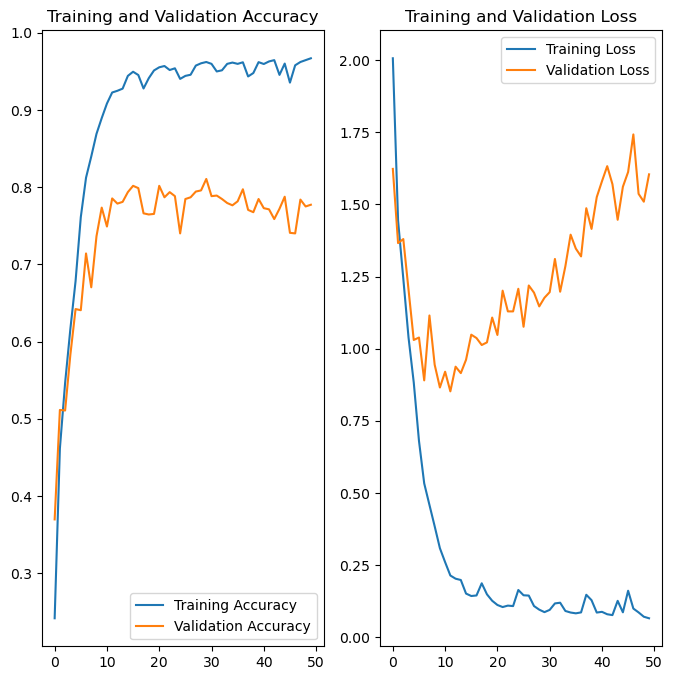

In [261]:
# for 50 Epochs without drop out MODEL 1
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

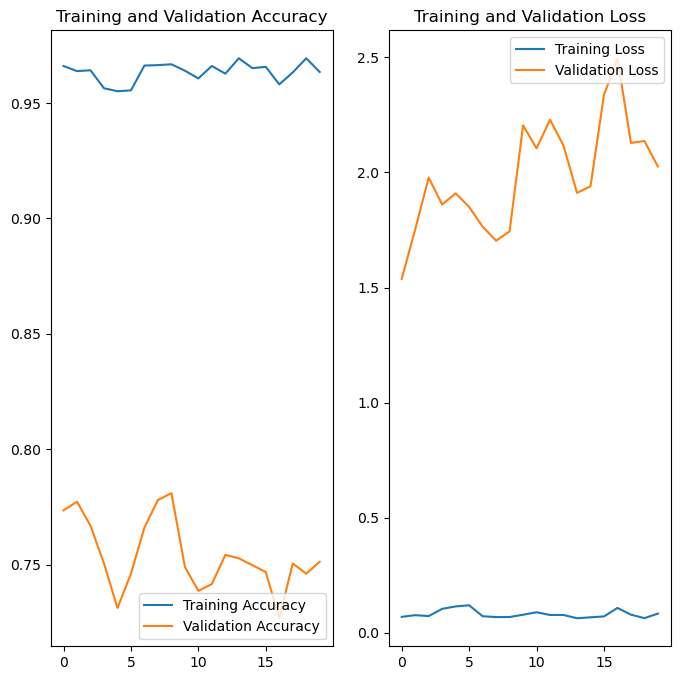

In [265]:
# for 20 Epochs without dropout MODEL 1
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

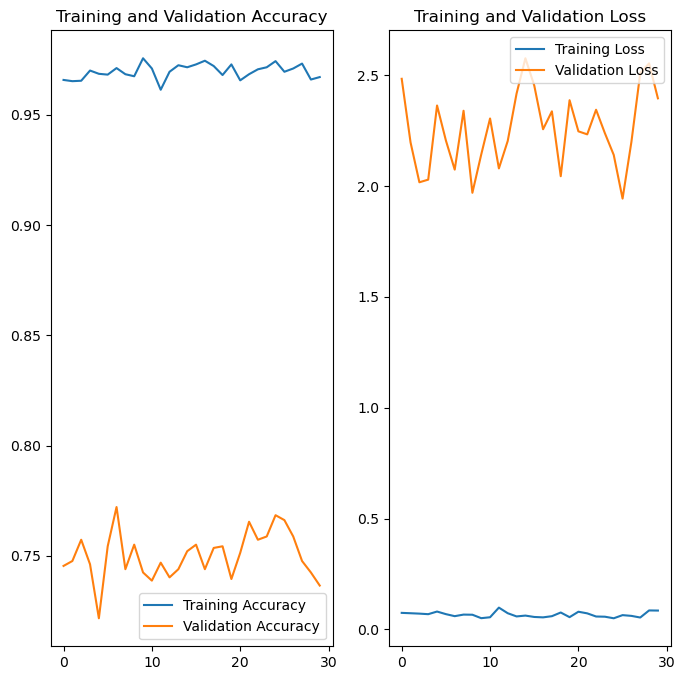

In [268]:
# for 30 Epochs without dropout using MODEL 1
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

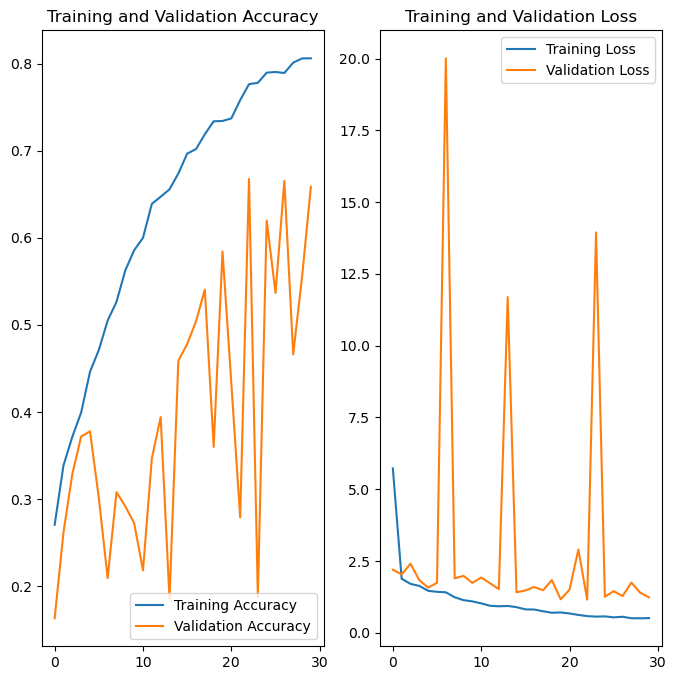

In [283]:
# for 30 Epochs WITH dropout model 2
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

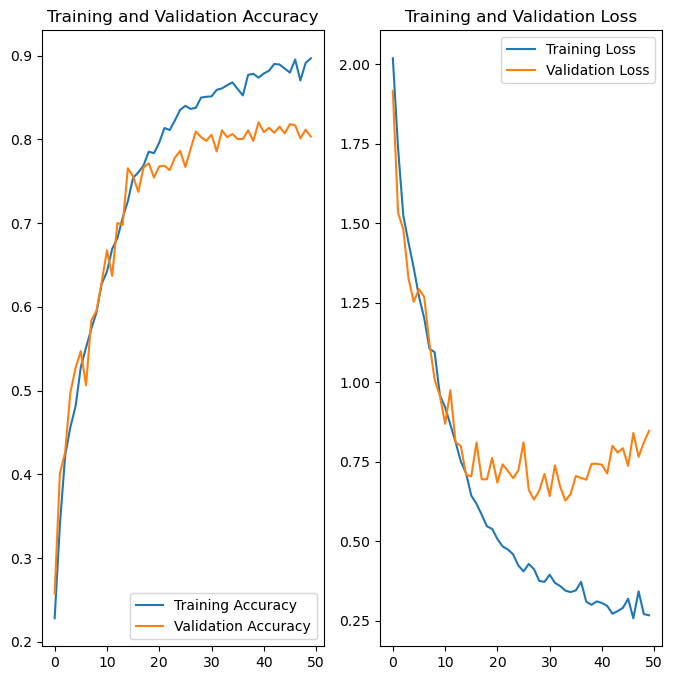

In [297]:
# for 50 Epochs WITH dropout model 3 FINAL
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Analysis of results 

Comparing Training Performance with and without Data Augmentation using same Model MODEL 3 FINAL

Training Accuracy:

Without Augmentation: Training accuracy increases steadily, reaching 0.5523 after 20 epochs.
With Augmentation: Training accuracy increases significantly faster, reaching 0.8986 after 50 epochs. This suggests data augmentation helps the model learn more complex patterns from the data.

Validation Accuracy:

Without Augmentation: Validation accuracy lags behind training accuracy throughout, with a gap of around 1-2%. This indicates potential overfitting.
With Augmentation: The gap between training and validation accuracy is smaller, suggesting less overfitting. Validation accuracy also reaches a higher value (0.8033) compared to the non-augmented case (0.5436).


Loss:

Without Augmentation: Both training and validation loss decrease gradually, but the validation loss shows some fluctuations.
With Augmentation: Both training and validation loss decrease more consistently compared to the non-augmented case.

Overall:

Data augmentation significantly improves the model's ability to learn from the data. This is evident in the faster and higher training accuracy achieved with augmentation. Additionally, the smaller gap between training and validation accuracy suggests reduced overfitting.

The number of training epochs used for each dataset is different (20 vs 50). It's important to consider running the non-augmented model for a longer duration to see if the gap between training and validation accuracy closes.

The training time per epoch is also longer for the data augmentation case (around 3x slower). This is a trade-off to consider when evaluating the overall effectiveness of the technique.

In conclusion, data augmentation appears to be a valuable technique for this specific dataset. It improves the model's ability to learn complex patterns and reduces overfitting. However, it's important to consider the computational cost associated with data augmentation.

Other MODELS show poor results, so ignored